# Мастерская № 2

## Введение 
### Описание
Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.
### Цель
Предсказать вероятность покупки в течение 90 дней
### Задачи
🔸 Изучить данные

🔸 Разработать полезные признаки

🔸 Создать модель для классификации пользователей

🔸 Улучшить модель и максимизировать метрику roc_auc 

🔸 Выполнить тестирование
### Данные
**apparel-purchases**
история покупок
- client_id идентификатор пользователя
- quantity количество товаров в заказе
- price цена товара
- category_ids вложенные категории, к которым отнсится товар 
- date дата покупки
- message_id идентификатор сообщения из рассылки
  
**apparel-messages**
история рекламных рассылок
- bulk_campaign_id идентификатор рекламной кампании
- client_id идентификатор пользователя
- message_id идентификатор сообщений
- event тип действия
- channel канал рассылки
- date дата рассылки
- created_at точное время создания сообщения

**apparel-target_binary**
совершит ли клиент покупку в течение следующих 90 дней
- client_id идентификатор пользователя 
- target целевой признак
  
**Результат**
Репозиторий на гитхабе:
- тетрадь jupyter notebook с описанием, подготовкой признаков, обучением модели и
тестированием
- описание проекта и инструкция по использованию в файле README.md
- список зависимостей в файле requirements.txt 

## Раздел 1. Изучение общей информации

###  1. Загрузка библиотек и функций

In [2]:
# Устанавливаем необходимые бибилиотеки
!pip install phik -q
!pip install scikit-learn --upgrade -q
!pip install shap==0.44.0 -q
!pip install lightgbm==3.3.5 -q
!pip install catboost -q

In [3]:
# Импортируем необходимые бибилиотеки и функции
import pandas as pd
import numpy as np
import re
import phik
import os
import shap
import seaborn as sns
import math
import lightgbm as lgb

from matplotlib import pyplot as plt
from datetime import datetime
from sklearn import svm
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

# создание констант
RANDOM_STATE = 42
TEST_SIZE = 0.25

##  2. Загрузка и изучение данных

In [5]:
# Проверяем пути к файлам на их наличие

pth1 = 'C:/Users/Family/My_projects/filtered_data/apparel-purchases.csv'
pth2 = 'C:/Users/Family/My_projects/filtered_data/apparel-messages.csv'
pth3 = 'C:/Users/Family/My_projects/filtered_data/apparel-target_binary.csv'

#pth1 = 'Start_ups/kaggle_startups_train_28062024.csv'
#pth2 = 'Start_ups/kaggle_startups_test_28062024.csv'

if os.path.exists(pth1):
    query_1 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    query_1 = pd.read_csv(pth2)
elif os.path.exists(pth3):
    query_1 = pd.read_csv(pth3)
else:
    print('Указанный путь к файлу не найден')

In [6]:
# Загружаем датафреймы
purchases = pd.read_csv(pth1)
messages = pd.read_csv(pth2)
target_binary = pd.read_csv(pth3)

<div class="alert alert-block alert-info">
    
<h3> Вывод по разделу 1 <a class="tocSkip"></h3>
    
Импортировал необходимые библиотеки и функции, задал константы.

Использовал проверку директорий с помощью библиотеки os, после чего загрузил датафреймы.   
</div>

## Раздел 2. Предобработка данных

### 1. Создание собственных функций

In [10]:
# функция проверки пропусков в столбцах датафрейма
def na_search (dataframe):
    print(f'В датафрейме {[x for x in globals() if globals()[x] is dataframe][0]}')
    count = 0
    for i in dataframe.columns:
        if dataframe[i].isna().sum() != 0:
            print(f'кол-во пропусков в столбцe {i} - {dataframe[i].isna().sum()}')    
            count +=1
    if count == 0:
        print('пропусков в данных нет')
    else:
        print('в остальных столбцах пропусков в данных нет')
    print()

In [11]:
# функция приведения названий столбцов к нижнему регистру и удаления пробелов в начале и конце
def snake_cols(dataframe):
    dataframe.columns = [re.sub(r'(?<!^)(?=[A-Z])','_',i).replace(' ','_').lower().strip() for i in dataframe.columns]

In [12]:
# функция удаления пробелов в начале и конце ячеек
def snake_text(dataframe):
    for i in dataframe.columns:
        if dataframe[i].dtype == 'object':
            dataframe[i] = dataframe[i].str.replace(' ','_').str.strip()

In [13]:
# функция проверки уникальных значений в текстовых столбцах
def unique_textcolumns (dataframe):
    for i in dataframe.columns:
        if dataframe[i].dtype == 'object':
            print(dataframe[i].value_counts())
            print()

<div class="alert alert-block alert-info">
    
<h3> Подвывод <a class="tocSkip"></h3>
    
Создал собственные функции для предобработки.  
</div>

### 2. Знакомство с данными, проверка на пропуски, преобразование типов данных, удаление дубликатов

In [16]:
# взглянем на purchases
purchases.info()
purchases.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [17]:
# преобразуем тип данных на корректный
purchases['date'] = pd.to_datetime(purchases['date'], format='%Y-%m-%d')

In [18]:
# проверяем на пропуски
na_search(purchases)

В датафрейме purchases
пропусков в данных нет



In [19]:
# проверяем на явные дубликаты
print(f'Количество явных дубликатов - {purchases.duplicated().sum()}')

Количество явных дубликатов - 73020


In [20]:
# посчитаем уникальных клиентов
len(purchases['client_id'].value_counts())

49849

In [21]:
# выведем частоту уникального количества товара
purchases['quantity'].value_counts()

quantity
1     201323
2        751
3         94
4         12
6          5
10         4
20         3
15         3
5          3
25         2
30         2
9          2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

<div class="alert alert-block alert-info">
    
<h3> Комментарий <a class="tocSkip"></h3>
    
Поскольку в подавляющем количестве случаев количество товаров в заказе равно единице, делаем вывод, что каждый дубликат - это второй (и последующий) товар в одном заказе, а не аномалия. Здесь дубликаты удалять не будем.
   
</div>

In [23]:
# выводим уникальные значения в текстовых столбцах
unique_textcolumns(purchases)

category_ids
['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
['4', '28', '244', '432']           6821
[]                                  5579
['4', '28', '275', '421']           4936
                                    ... 
['4', '5837', '5836', '839']           1
['5562', '5632', '5552', '1089']       1
['4', '27', '278', '471']              1
['5562', '5697', '5651', '1153']       1
['5562', '5597', '5696', '5529']       1
Name: count, Length: 933, dtype: int64

message_id
1515915625489095763-6251-6311b13a4cf78     365
1515915625624308268-7803-636dfea7ca890     218
1515915625880116527-8725-639b2f0ad5e2e     160
1515915625607113301-13818-650a8af70fd67    148
1515915625558691508-14212-6567128370bdd    143
                                          ... 
1515915625487887289-5707-62e38257ccade       1
1515915625597731503-5707-62e38247a88c0       1
1515915625594604191-5707-62e382458eb5f       1
1515915625594340883-5739-62e3d2d9c35c2       1
151591562549532

In [24]:
# преобразуем значения category_ids в список
purchases['category_ids'] = purchases['category_ids'].str.replace('[', '').str.replace(']', '').str.replace(" ", '').str.replace("'", '')

In [25]:
# создаем столбец с основной категорией
purchases['main_category'] = purchases['category_ids'].str.split(",", expand=True)[0] \
 #                            + '_' + purchases['category_ids'].str.split(",", expand=True)[1].astype('object')
# заменяем значения None и пропуски
purchases.loc[purchases['main_category'] == 'None', 'main_category'] = '99'
purchases.loc[purchases['main_category'] == '', 'main_category'] = '999'

In [26]:
# удаляем столбец category_ids
purchases = purchases.drop(columns=['category_ids'])

In [27]:
# взглянем на messages
messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [28]:
# проверяем на явные дубликаты
print(f'Количество явных дубликатов - {messages.duplicated().sum()}')

Количество явных дубликатов - 48610


<div class="alert alert-block alert-info">
    
<h3> Комментарий <a class="tocSkip"></h3>
    
Здесь дубликаты - аномалии, т.к. идентично все, включая точное время (до секунды) создания сообщения. Будем эти дубликаты удалять.
   
</div>

In [30]:
# удаляем явные дубликаты
messages = messages.drop_duplicates()

In [31]:
# преобразуем тип данных на корректный
messages['date'] = pd.to_datetime(messages['date'], format='%Y-%m-%d')
messages['created_at'] = pd.to_datetime(messages['created_at'], format='%Y-%m-%d %H:%M:%S')

In [32]:
# посчитаем строки где разность между date и created_at больше суток
messages.query('abs((date - created_at).dt.days) > 1')['created_at'].count()

0

In [33]:
# таких строк нет, значит удаляем один из этих столбцов как избыточный
messages = messages.drop(columns=["created_at"])

In [34]:
# проверяем на пропуски
na_search(messages)

В датафрейме messages
пропусков в данных нет



In [35]:
# посчитаем уникальных клиентов
len(messages['client_id'].value_counts())

53329

In [36]:
# выводим уникальные значения в текстовых столбцах
unique_textcolumns(messages)

message_id
1515915625489095763-6251-6311b13a4cf78     1427
1515915625490540122-6973-633edf707840d      438
1515915625490241385-6973-633edf70723d8      438
1515915625629509124-6374-63241bd1541d5      286
1515915625488270582-3433-6232d6007e929      249
                                           ... 
1515915625489968543-12052-64426bfcee0e6       1
1515915625500268486-12052-64426bfce782f       1
1515915625487017808-12052-64426bfce74d5       1
1515915625488469540-12052-64426bfce6d10       1
1515915625491736359-14656-65ce97f92a3fd       1
Name: count, Length: 9061667, dtype: int64

event
send           9058174
open           3052481
click           483326
purchase         62593
hard_bounce      19763
soft_bounce      10582
unsubscribe       2833
hbq_spam           823
complain           527
subscribe           85
close                1
Name: count, dtype: int64

channel
mobile_push    7470472
email          5220716
Name: count, dtype: int64



In [37]:
# взглянем на target_binary
target_binary.info()
target_binary.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [38]:
# проверяем на явные дубликаты
print(f'Количество явных дубликатов - {target_binary.duplicated().sum()}')

Количество явных дубликатов - 0


### 2. Создание общей таблицы

In [40]:
# взглянем на покупки одного клиента
purchases.query('client_id == 1515915625468061170')

,client_id,quantity,price,date,message_id,main_category
95806,1515915625468061170,1,7.0,2023-03-26,1515915625468061170-11144-641ad2cda77a2,999
95807,1515915625468061170,1,7.0,2023-03-26,1515915625468061170-11144-641ad2cda77a2,999
95808,1515915625468061170,1,2699.0,2023-03-26,1515915625468061170-11144-641ad2cda77a2,2
95809,1515915625468061170,1,2699.0,2023-03-26,1515915625468061170-11144-641ad2cda77a2,2
96090,1515915625468061170,1,2199.0,2023-03-29,1515915625468061170-11208-6423f082d2fcb,4
96091,1515915625468061170,1,2199.0,2023-03-29,1515915625468061170-11208-6423f082d2fcb,4
96092,1515915625468061170,1,1609.0,2023-03-29,1515915625468061170-11208-6423f082d2fcb,4
96093,1515915625468061170,1,1609.0,2023-03-29,1515915625468061170-11208-6423f082d2fcb,4
96094,1515915625468061170,1,2195.0,2023-03-29,1515915625468061170-11208-6423f082d2fcb,4
96095,1515915625468061170,1,2195.0,2023-03-29,1515915625468061170-11208-6423f082d2fcb,4


In [41]:
# создадим столбец с общей стоимостью покупки в строке
purchases['total_price'] = purchases['price'] * purchases['quantity']

In [42]:
# создаем группированный по клиентам датафрейм
purchases_groupby_clients_ID = purchases.drop(columns=["price", "quantity", 'main_category', 'date', 'message_id']).groupby(by='client_id').sum()

In [43]:
#взглянем на датафрейм
purchases_groupby_clients_ID.info()
purchases_groupby_clients_ID.head()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   total_price  49849 non-null  float64
dtypes: float64(1)
memory usage: 778.9 KB


,total_price
client_id,
1515915625468060902,6993.0
1515915625468061003,16235.0
1515915625468061099,299.0
1515915625468061100,2098.0
1515915625468061170,33601.0


In [44]:
# создадим столбец с количеством дней покупок для каждого клиента
purchases_groupby_clients_ID['dates'] = purchases.drop(columns=["price", "quantity",'main_category', 'total_price', 'message_id']) \
                                                 .groupby(by='client_id').nunique()['date']
# создадим столбец с последней датой покупки
purchases_groupby_clients_ID['last_data'] = purchases.drop(columns=["price", "quantity",'main_category', 'total_price', 'message_id']) \
                                                 .groupby(by='client_id').max()['date']
# создадим столбец с первой датой покупки
purchases_groupby_clients_ID['first_data'] = purchases.drop(columns=["price", "quantity",'main_category', 'total_price', 'message_id']) \
                                                 .groupby(by='client_id').min()['date']
# создадим столбец со сроком давности последней покупки (сколько дней назад)
purchases_groupby_clients_ID['last_purch'] = (purchases_groupby_clients_ID['last_data'].max() - purchases_groupby_clients_ID['last_data']).dt.days + 1

# создадим столбец с периодом покупок покупателем
purchases_groupby_clients_ID['period'] = (purchases_groupby_clients_ID['last_data'] - purchases_groupby_clients_ID['first_data']).dt.days + 1

# создадим столбец со средней периодичностью покупок
purchases_groupby_clients_ID['mean_period'] = round((purchases_groupby_clients_ID['period'] / purchases_groupby_clients_ID['dates']), 0)

# создадим столбец со средней стоимостью чека
purchases_groupby_clients_ID['mean_bill'] = round((purchases_groupby_clients_ID['total_price'] / purchases_groupby_clients_ID['dates']), 0)

# создадим столбец с количеством единиц купленного товара для каждого клиента
purchases_groupby_clients_ID['quantity'] = purchases.drop(columns=['price', 'date','main_category', 'total_price', 'message_id']) \
                                                 .groupby(by='client_id').sum()['quantity']

# создадим столбец со средним значением количества уникальных категорий купленных товаров в день
purchases_groupby_clients_ID['quant_mean'] =round((purchases_groupby_clients_ID['quantity'] / purchases_groupby_clients_ID['dates']), 2)

# создадим столбец с количеством уникальных категорий купленных товаров 
purchases_groupby_clients_ID['cat_counts'] = purchases.drop(columns=["price", "quantity",'date', 'total_price', 'message_id']) \
                                                 .groupby(by='client_id').nunique()['main_category']
# создадим столбец со средним значением количества уникальных категорий купленных товаров в день
#purchases_groupby_clients_ID['cat_mean'] =round((purchases_groupby_clients_ID['cat_counts'] / purchases_groupby_clients_ID['dates']), 2)
#
# создадим столбец с доминирующей категорией купленных товаров 
purchases_groupby_clients_ID['main_category'] = pd.pivot_table(purchases, values='main_category', index=['client_id'], aggfunc='max')['main_category']
purchases_groupby_clients_ID['main_category'] = purchases_groupby_clients_ID['main_category'].replace(np.nan, '999')
# удаляем лишние столбцы
purchases_groupby_clients_ID = purchases_groupby_clients_ID.drop(columns=['last_data', 'first_data'])

In [45]:
messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19


In [46]:
# создаем новые столбцы с положительными событиями
messages.loc[messages['channel'] == 'email', 'email'] = 1 
messages.loc[messages['channel'] == 'mobile_push', 'mobile_push'] = 1 
messages['email'].astype('bool')
messages['mobile_push'].astype('bool')
for _ in ['open','click','purchase','subscribe']:
    messages.loc[messages['event'] == _, _] = 1
    messages[_].astype('bool')      

In [47]:
# создаем группированный по клиентам датафрейм
messages_groupby_clients_ID = messages.drop(columns=['bulk_campaign_id', 'message_id', 'event', 'date', 'channel']).groupby(by='client_id').sum()

In [48]:
# еще раз взглянем на датафреймы
purchases_groupby_clients_ID.info()
purchases_groupby_clients_ID.head()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   total_price    49849 non-null  float64
 1   dates          49849 non-null  int64  
 2   last_purch     49849 non-null  int64  
 3   period         49849 non-null  int64  
 4   mean_period    49849 non-null  float64
 5   mean_bill      49849 non-null  float64
 6   quantity       49849 non-null  int64  
 7   quant_mean     49849 non-null  float64
 8   cat_counts     49849 non-null  int64  
 9   main_category  49849 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 4.2+ MB


,total_price,dates,last_purch,period,mean_period,mean_bill,quantity,quant_mean,cat_counts,main_category
client_id,,,,,,,,,,
1515915625468060902,6993.0,1,631,1,1.0,6993.0,7,7.00,1,4
1515915625468061003,16235.0,1,409,1,1.0,16235.0,7,7.00,1,4
1515915625468061099,299.0,1,641,1,1.0,299.0,1,1.00,1,4
1515915625468061100,2098.0,1,7,1,1.0,2098.0,2,2.00,1,4
1515915625468061170,33601.0,3,245,84,28.0,11200.0,19,6.33,3,999


In [49]:
messages_groupby_clients_ID.head()

,email,mobile_push,open,click,purchase,subscribe
client_id,,,,,,
1515915625468060902,177.0,0.0,35.0,10.0,5.0,0.0
1515915625468061003,165.0,0.0,5.0,5.0,1.0,0.0
1515915625468061099,182.0,94.0,51.0,8.0,0.0,0.0
1515915625468061100,0.0,428.0,157.0,1.0,1.0,0.0
1515915625468061170,202.0,91.0,31.0,16.0,3.0,0.0


In [50]:
full = target_binary.join(purchases_groupby_clients_ID, on='client_id')

In [51]:
full = full.join(messages_groupby_clients_ID, on='client_id')

In [52]:
full.info()
full.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   client_id      49849 non-null  int64  
 1   target         49849 non-null  int64  
 2   total_price    49849 non-null  float64
 3   dates          49849 non-null  int64  
 4   last_purch     49849 non-null  int64  
 5   period         49849 non-null  int64  
 6   mean_period    49849 non-null  float64
 7   mean_bill      49849 non-null  float64
 8   quantity       49849 non-null  int64  
 9   quant_mean     49849 non-null  float64
 10  cat_counts     49849 non-null  int64  
 11  main_category  49849 non-null  object 
 12  email          41982 non-null  float64
 13  mobile_push    41982 non-null  float64
 14  open           41982 non-null  float64
 15  click          41982 non-null  float64
 16  purchase       41982 non-null  float64
 17  subscribe      41982 non-null  float64
dtypes: flo

,client_id,target,total_price,dates,last_purch,period,mean_period,mean_bill,quantity,quant_mean,cat_counts,main_category,email,mobile_push,open,click,purchase,subscribe
0,1515915625468060902,0,6993.0,1,631,1,1.0,6993.0,7,7.00,1,4,177.0,0.0,35.0,10.0,5.0,0.0
1,1515915625468061003,1,16235.0,1,409,1,1.0,16235.0,7,7.00,1,4,165.0,0.0,5.0,5.0,1.0,0.0
2,1515915625468061099,0,299.0,1,641,1,1.0,299.0,1,1.00,1,4,182.0,94.0,51.0,8.0,0.0,0.0
3,1515915625468061100,0,2098.0,1,7,1,1.0,2098.0,2,2.00,1,4,0.0,428.0,157.0,1.0,1.0,0.0
4,1515915625468061170,0,33601.0,3,245,84,28.0,11200.0,19,6.33,3,999,202.0,91.0,31.0,16.0,3.0,0.0


<div class="alert alert-block alert-info">
    
<h3> Вывод по разделу 2 <a class="tocSkip"></h3>
    
Провел предобработку данных: проверил на пропуски и удалил, где это оправдано, заменил типы данных на корректные, синтезировал новые признаки, удалил неинформативные. Произвел объединение датафреймов по ID клиентов.
</div>

## Раздел 3. Исследовательский анализ данных

In [61]:
# создание функции построения графиков для количественных и категориальных столбцов датафрейма в зависимости от таргета
def stat_plot(dataframe):
    k = 0
    cols = dataframe.select_dtypes(include=['number']).columns.tolist()
    n = len(cols)
    plt.figure(figsize=(15, 6*n))
    for i in cols:
        k += 1
        plt.subplot(n,2,k)
        sns.histplot(data=dataframe, x=i, hue='target',stat="density", common_norm=False)
        #dataframe[i].plot(kind='hist', hue=target, bins=50)
        plt.title('Гистограмма распределения значений столбца "' + i +'"')
        plt.xlabel('Значение столбца "' + i +'"')
        plt.ylabel('Частота встречаемости')
        k += 1
        plt.subplot(n,2,k)
        dataframe[i].plot(kind='box')
        plt.title('Диаграмма размаха значений столбца "' + i +'"')
        plt.ylabel('Значения столбца "' + i +'"')        
    plt.show()
   
    cols = dataframe.select_dtypes(exclude=['number','datetime']).columns.tolist()
    n = len(cols)
    plt.figure(figsize=(30, 10*n))
    for i in cols:        
        sns.catplot(data=dataframe, y=i,  kind="count", hue='target', palette="pastel", edgecolor=".6")
        plt.title('Гистограмма распределения значений столбца "' + i +'"')
        #plt.xlabel('Частота встречаемости')
        #plt.ylabel('Значение столбца "' + i +'"')             
    plt.show()

In [63]:
# вывод описательных статистик startups_train
full.drop(columns=['client_id']).describe()

,target,total_price,dates,last_purch,period,mean_period,mean_bill,quantity,quant_mean,cat_counts,email,mobile_push,open,click,purchase,subscribe
count,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000,41982.000000
mean,0.019278,4865.584264,1.207808,362.931593,22.132199,9.461694,4043.233204,4.082710,3.332598,1.224137,114.932781,145.016650,59.199157,10.575247,1.326854,0.001810
std,0.137503,7351.467229,0.665728,185.301691,76.842637,31.154245,5549.150867,5.562927,3.779888,0.502536,92.601646,145.431263,73.397034,13.788413,1.311738,0.047285
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1499.000000,1.000000,234.000000,1.000000,1.000000,1499.000000,1.000000,1.000000,1.000000,12.000000,0.000000,4.000000,3.000000,1.000000,0.000000
50%,0.000000,2969.000000,1.000000,349.000000,1.000000,1.000000,2598.000000,2.000000,2.000000,1.000000,122.000000,121.000000,26.000000,6.000000,1.000000,0.000000
75%,0.000000,5698.000000,1.000000,543.000000,1.000000,1.000000,4898.000000,5.000000,4.000000,1.000000,184.000000,241.000000,94.000000,13.000000,1.000000,0.000000
max,1.000000,540408.000000,41.000000,642.000000,637.000000,310.000000,387583.000000,355.000000,111.000000,6.000000,870.000000,2294.000000,1268.000000,380.000000,81.000000,3.000000


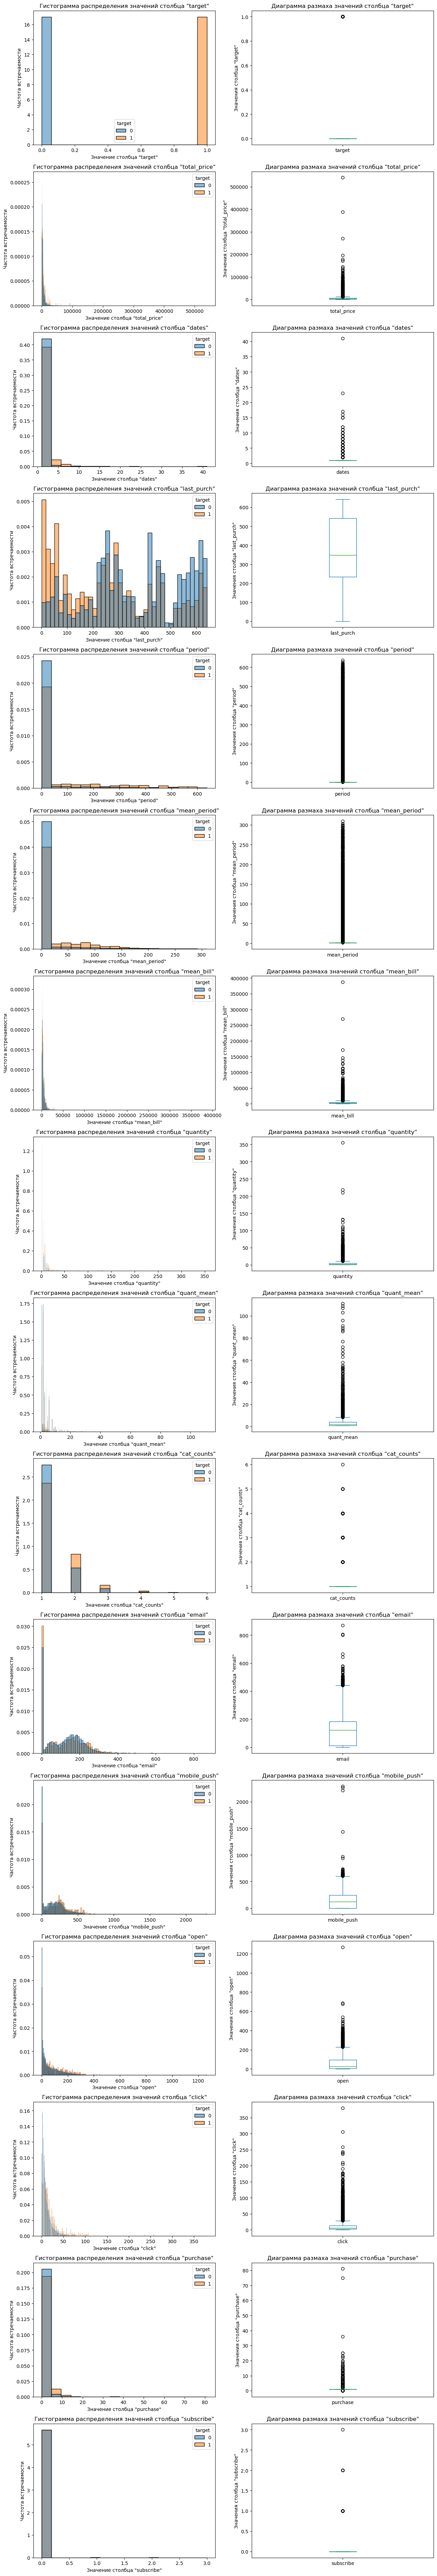

The figure layout has changed to tight


<Figure size 3000x1000 with 0 Axes>

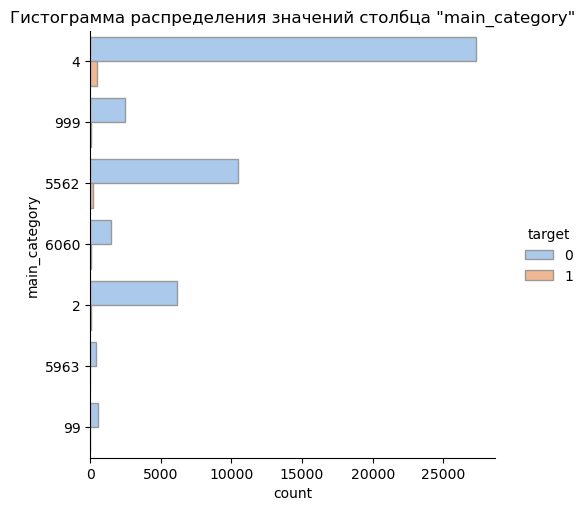

In [65]:
# строим гистограмму частотности распределения и ящик с усами для количественных столбцов и графики для категориальных
stat_plot(full.drop(columns=['client_id']))

In [61]:
# создаем синтетические признаки - квадраты
#for i in ['total_price', 'dates', 'mean_bill', 'quantity','quant_mean']:
#    full[i+'_v2'] = full[i] * full[i]

In [68]:
# логарифмируем численные столбцы для нормализации графиков
for i in ['total_price', 'dates', 'mean_bill', 'quantity','quant_mean']:
    full[i] = np.log2(full[i])

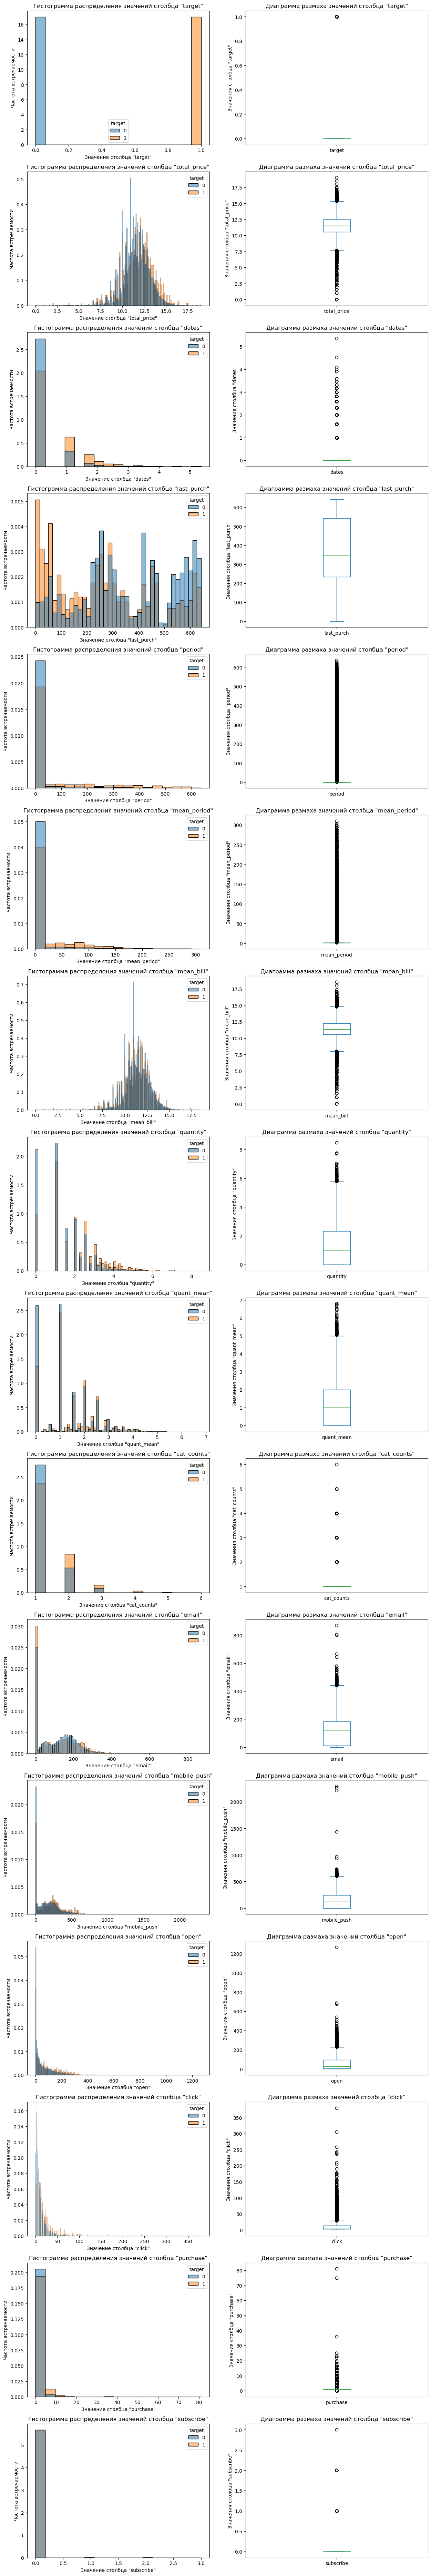

The figure layout has changed to tight


<Figure size 3000x1000 with 0 Axes>

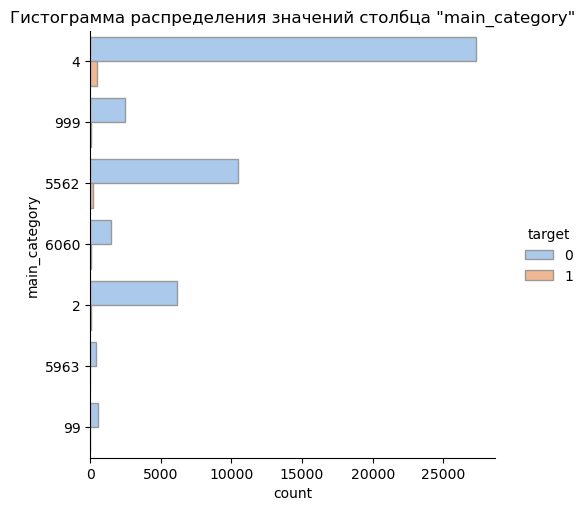

In [70]:
# повторно строим гистограмму частотности распределения и ящик с усами для количественных столбцов и графики для категориальных
stat_plot(full.drop(columns=['client_id']))

<div class="alert alert-block alert-info">
    
<h3> Вывод по разделу 3 <a class="tocSkip"></h3>
    
Провел исследовательский анализ данных по таргету для численных и категориальных столбцов. Провел логарифмирование некоторых столбцов для придания распределению более нормального вида. Визуально есть различия в данных по таргету, что говорит о возможности создания модели бинарной классификации на этих данных.
</div>

## Раздел 4. Корреляционный анализ

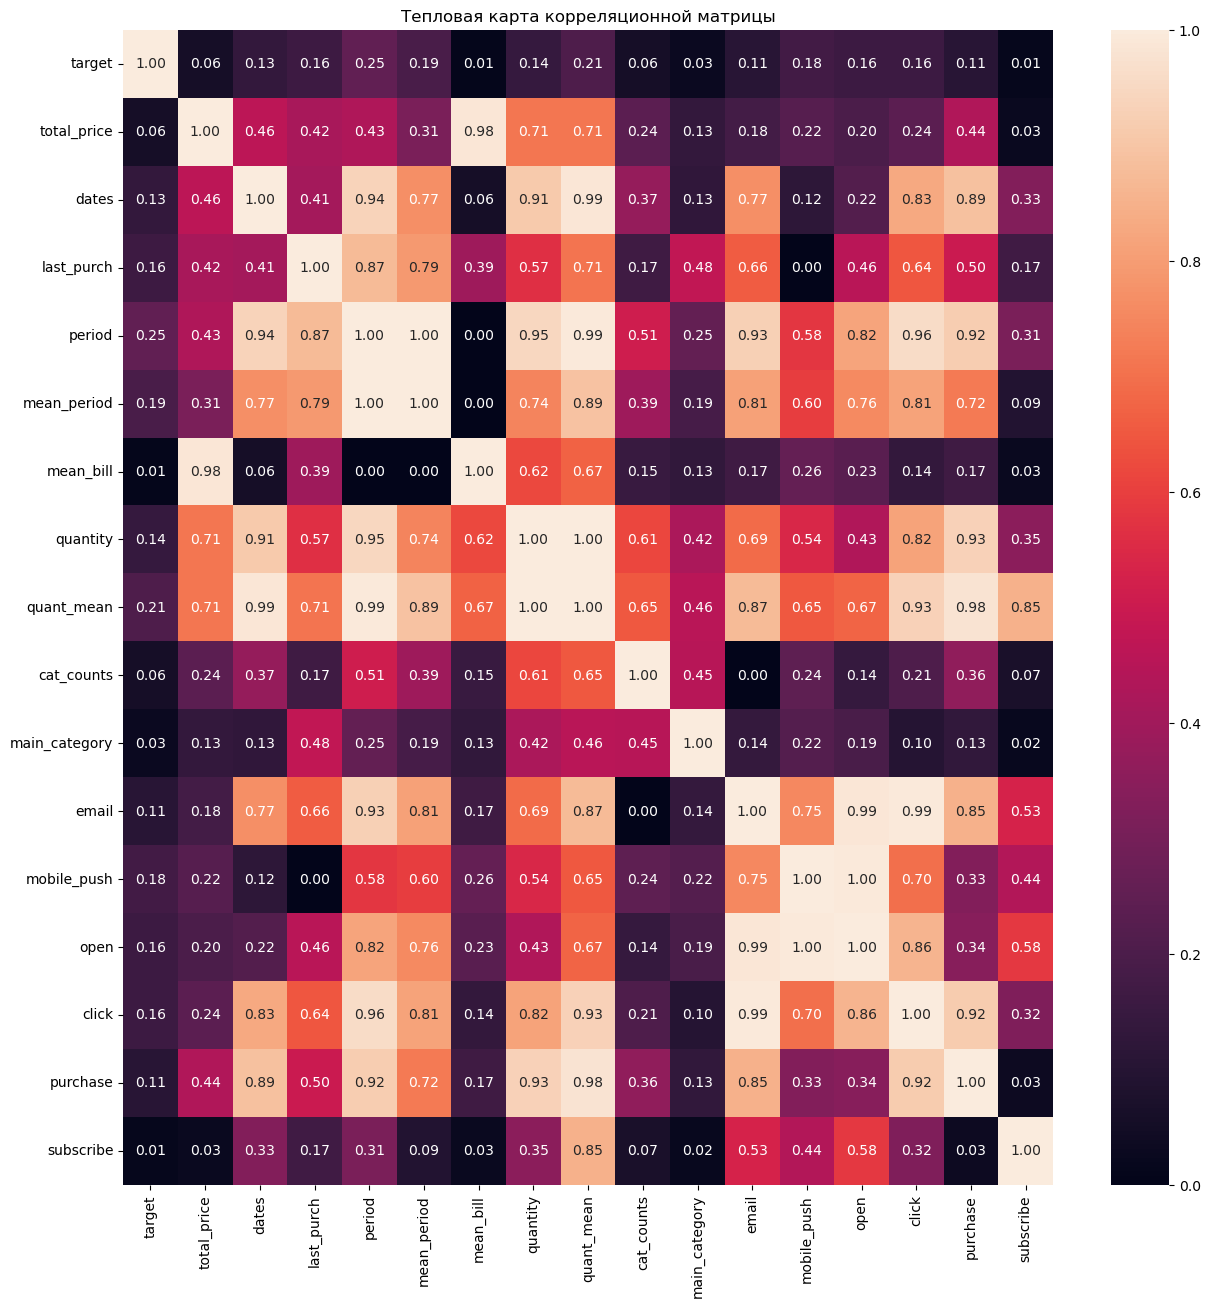

In [75]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(full.drop(columns=['client_id']).phik_matrix(interval_cols=['total_price','mean_bill','total_price_v2','mean_bill_v2']), \
            annot=True, fmt='.2f')
plt.title('Тепловая карта корреляционной матрицы') 
plt.show()

<div class="alert alert-block alert-info">
    
<h3> Вывод по разделу 4 <a class="tocSkip"></h3>
    
Провел корреляционный анализ данных для определения коллинеарности и первичного анализа зависимости таргета от признаков. Коллинеарные признаки с высокими показателями корреляции удалим перед разбиением датасета на тренировочные и тестовые данные.
</div>

## Раздел 5. Использование пайплайнов

In [78]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   client_id      49849 non-null  int64  
 1   target         49849 non-null  int64  
 2   total_price    49849 non-null  float64
 3   dates          49849 non-null  float64
 4   last_purch     49849 non-null  int64  
 5   period         49849 non-null  int64  
 6   mean_period    49849 non-null  float64
 7   mean_bill      49849 non-null  float64
 8   quantity       49849 non-null  float64
 9   quant_mean     49849 non-null  float64
 10  cat_counts     49849 non-null  int64  
 11  main_category  49849 non-null  object 
 12  email          41982 non-null  float64
 13  mobile_push    41982 non-null  float64
 14  open           41982 non-null  float64
 15  click          41982 non-null  float64
 16  purchase       41982 non-null  float64
 17  subscribe      41982 non-null  float64
dtypes: flo

In [83]:
# пропуски заполним нулями
full = full.fillna(0)
# разбиваем датасет на тренировочную и тестовую выборки с удалением коллинеарных и лишних признаков
X_train, X_test, y_train, y_test = train_test_split(
    full.drop(['subscribe','client_id', 'target', 'quant_mean'], axis=1),
    full['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = full['target']
)

In [85]:
# создаём списки с названиями признаков
ohe_columns = X_train.select_dtypes(exclude='number').columns
num_columns = X_train.select_dtypes(include='number').columns

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(strategy='mean')),
     ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ]
    )

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
     #словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(45,60),
        'models__max_features': range(35,50),
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3,7), 
        'preprocessor__num': [StandardScaler(),  'passthrough']   
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__C': [3, 3.5, 3.7, 3.8, 4, 5],        
        'preprocessor__num': [StandardScaler(),  'passthrough']  
    },
    
    # словарь для модели RandomForestClassifier
    {
        'models': [RandomForestClassifier()],
        'models__n_estimators':range(50, 60),
        'models__max_depth': range(20, 30),        
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },
    
    # словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(loss_function="Logloss")],
        'models__iterations':range(20, 100),
        'models__max_depth': range(7, 10),   
        'models__learning_rate':[0.5, 0.68, 0.7, 0.8],
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    },
    
    # словарь для модели LGBMClassifier
    {
        'models': [LGBMClassifier()],
        'models__n_estimators':range(25, 100),
        'models__num_leaves': range(20, 40),        
        'models__reg_alpha': [0.1, 0.2, 0.5],
        'preprocessor__num': [StandardScaler(), 'passthrough']
    }
]
grid = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE,
    n_iter=50    
)
grid.fit(X_train, y_train)

print('Лучшая модель и её параметры:')
display(grid.best_estimator_.named_steps['models'])

print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_.round(4))

0:	learn: 0.3468706	total: 149ms	remaining: 3.43s
1:	learn: 0.2160332	total: 165ms	remaining: 1.82s
2:	learn: 0.1536646	total: 185ms	remaining: 1.3s
3:	learn: 0.1215857	total: 200ms	remaining: 1000ms
4:	learn: 0.1039747	total: 215ms	remaining: 816ms
5:	learn: 0.0946465	total: 230ms	remaining: 689ms
6:	learn: 0.0900966	total: 244ms	remaining: 593ms
7:	learn: 0.0873131	total: 263ms	remaining: 525ms
8:	learn: 0.0856344	total: 282ms	remaining: 469ms
9:	learn: 0.0846660	total: 298ms	remaining: 418ms
10:	learn: 0.0839995	total: 316ms	remaining: 373ms
11:	learn: 0.0836580	total: 330ms	remaining: 330ms
12:	learn: 0.0833950	total: 345ms	remaining: 292ms
13:	learn: 0.0826926	total: 364ms	remaining: 260ms
14:	learn: 0.0823426	total: 392ms	remaining: 235ms
15:	learn: 0.0821603	total: 410ms	remaining: 205ms
16:	learn: 0.0819653	total: 426ms	remaining: 175ms
17:	learn: 0.0814041	total: 442ms	remaining: 147ms
18:	learn: 0.0812984	total: 457ms	remaining: 120ms
19:	learn: 0.0811311	total: 472ms	remaini

Метрика лучшей модели на тренировочной выборке: 0.7369


In [86]:
# делаем предскзание на тестовых данных
y_pred = grid.predict(X_test)
y_predict_probas = grid.predict_proba(X_test)
# замеряем метрику на тестовых данных
print(f'Метрика ROC AUC на тестовых данных равна {round(roc_auc_score(y_test, y_predict_probas[:,1]), 3)}')

Метрика ROC AUC на тестовых данных равна 0.745


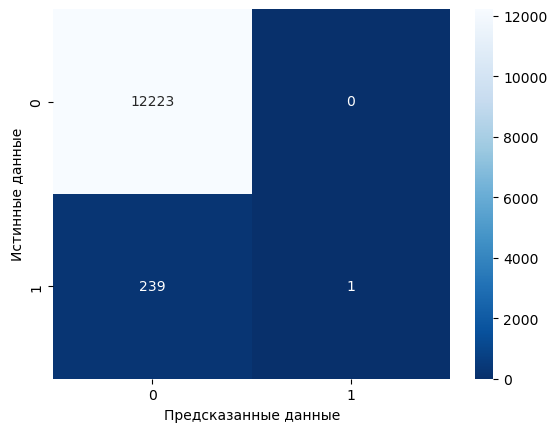

In [87]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Истинные данные')
plt.xlabel('Предсказанные данные')
plt.show()

<div class="alert alert-block alert-info">
    
<h3> Вывод по разделу 5 <a class="tocSkip"></h3>
    
Разбил данные на тренировочную и тестовую выборки. Создал пайплайн для подбора гиперпараметров нескольких моделей. Получил требуемые показатели метрики. Сделал предсказания на лучшей модели. Дополнительно построил матрицу ошибок. Модель сносит все к нулевому значению таргета. Результаты такого прогноза могут быть непрактичны. Как рекомендация для заказчика - выбор другой метрики для фокусного определения истинно-положительных значений как основной для бизнеса в данном типе задач.
</div>

<div class="alert alert-block alert-info">
    
<h3> Общий вывод <a class="tocSkip"></h3>
    
Проведено исследование для Интернет-магазина, который собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов определены пользователи, которые готовы совершить покупку в ближайшее время. В исследовании последовательно решены задачи предобработки и изучения данных, разработки синтетических полезных признаков, создания модели для классификации пользователей и ее улучшения путем перебора гиперпараметров в пайплайне с максимизацией метрики roc_auc. Лучшей моделью определена CatBoostClassifier с метрикой 0,736 на тренировочных данных (требование заказчика метрика больше 0,7 выполнено). На заключительном этапе сделан прогноз на тестовых данных. 

</div>